In [ ]:
%pip install pandas numpy seaborn matplotlib scikit-learn joblib xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


🔄 Loading Data...
✅ Saved scaler and label encoder

🚀 STARTING MODEL TRAINING & COMPARISON...
Training Random Forest...
   ✅ Random Forest Accuracy: 83.64%
Training XGBoost...
   ✅ XGBoost Accuracy: 83.82%
Training SVM...
   ✅ SVM Accuracy: 83.91%
🏆 WINNER: SVM with 83.9% Accuracy


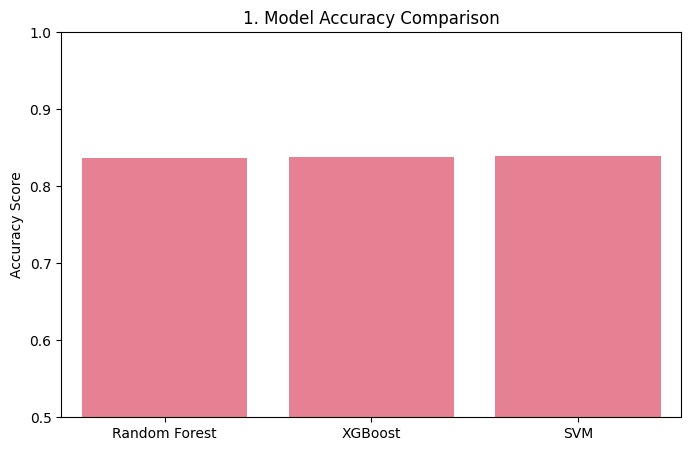

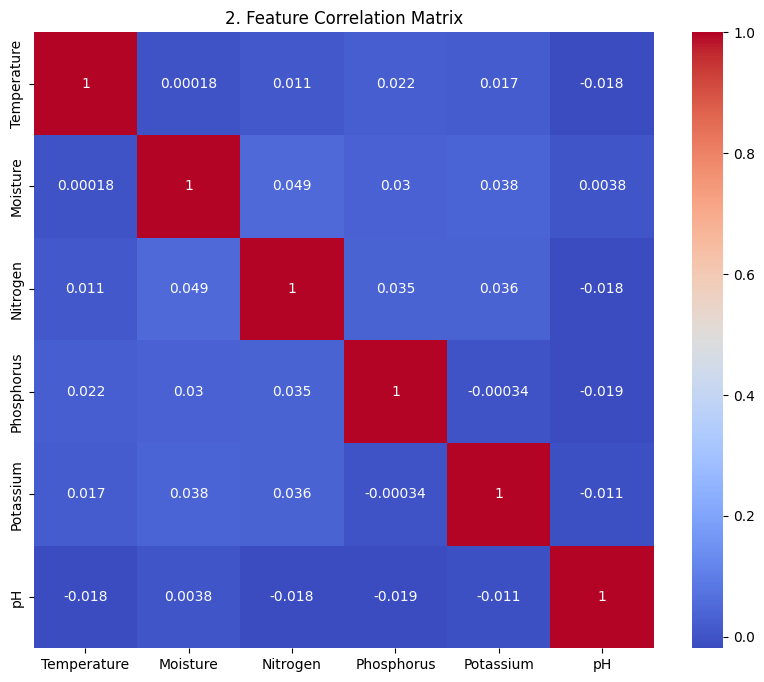

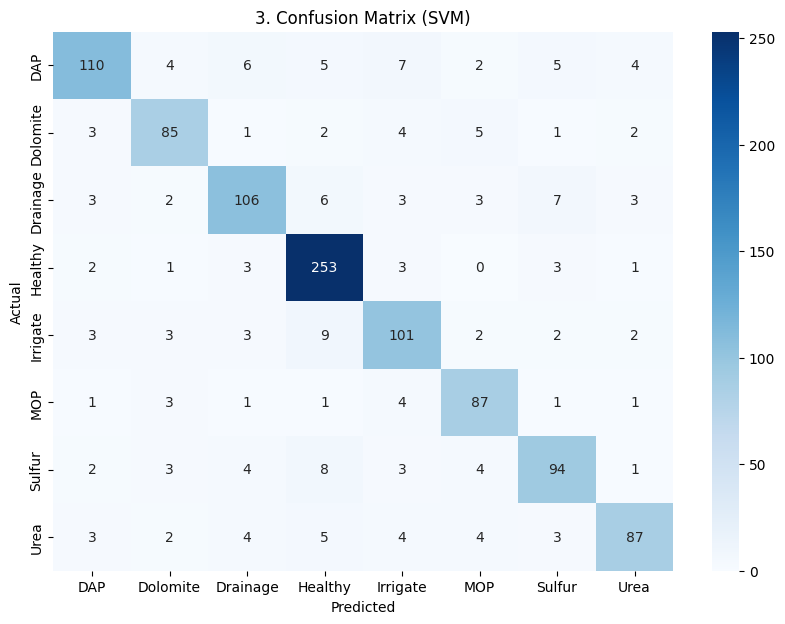

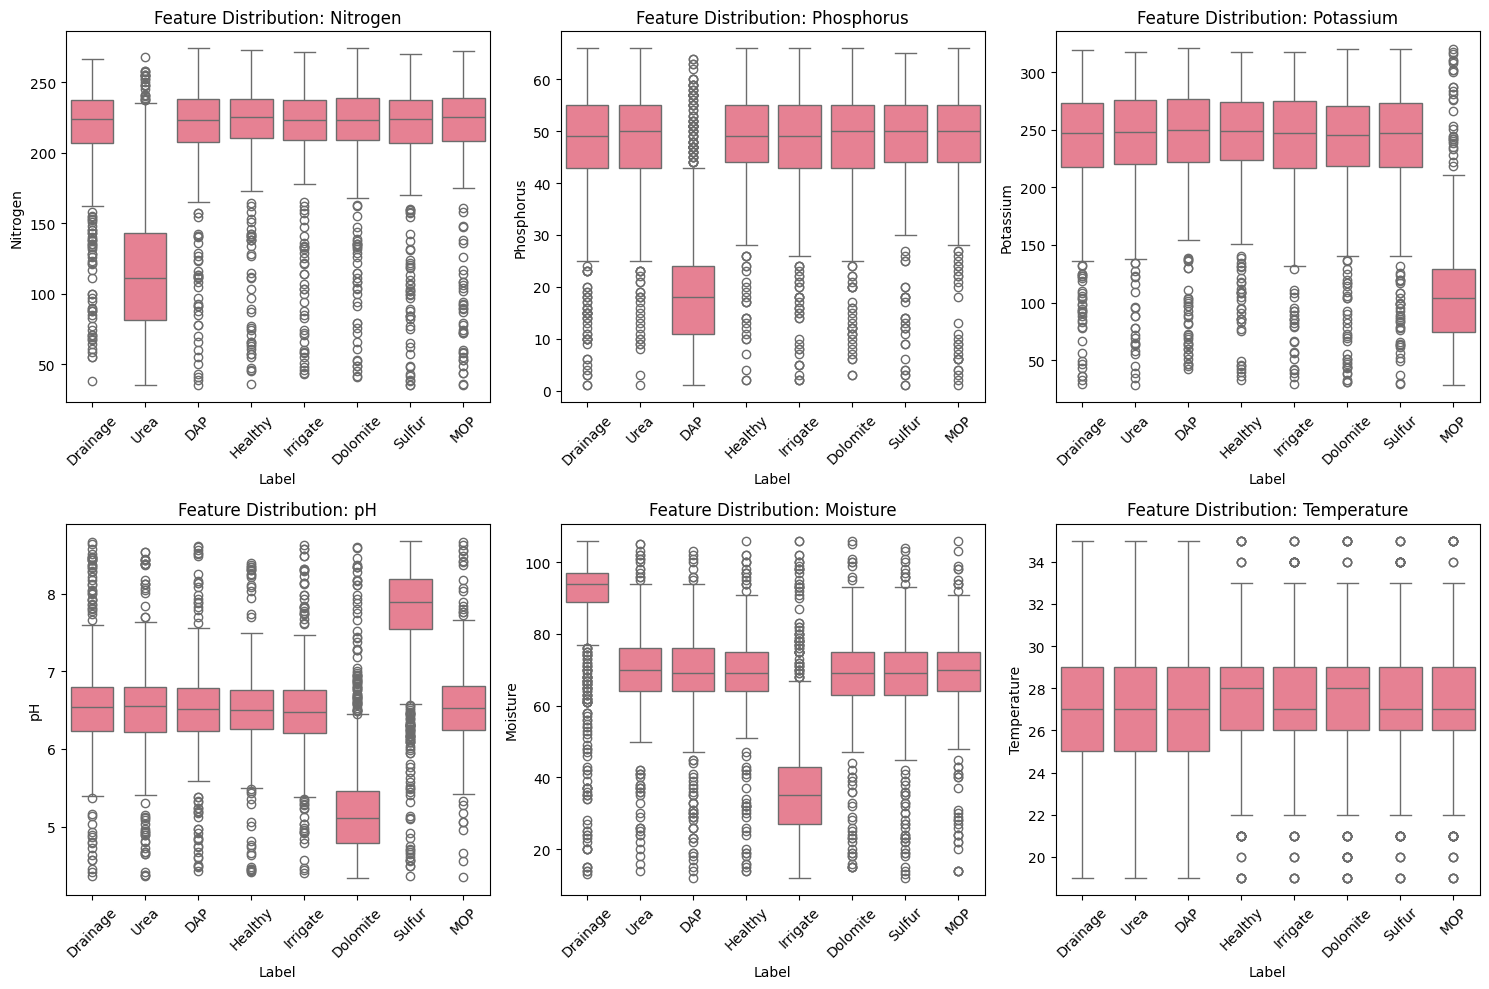

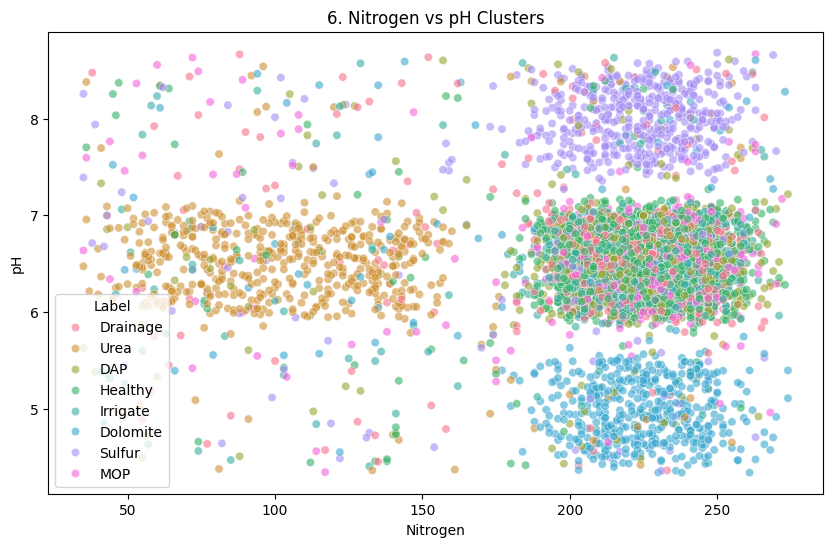

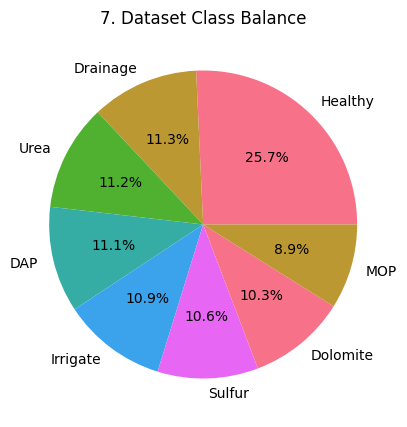


🔧 Starting Hyperparameter Tuning for Random Forest...
   ✅ Best Params: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
   ✅ Best Tuned Accuracy: 83.64%

🎉 ALL DONE! Check the 'model_results' folder for your graphs.
✅ Models, scaler, and encoder are ready for app.py!


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings('ignore')

# 1. SETUP & LOADING
# ---------------------------------------------------------
print("🔄 Loading Data...")
df = pd.read_csv("realistic_soil_data.csv")
output_folder = "model_results"
import os
if not os.path.exists(output_folder): os.makedirs(output_folder)

# Preprocessing
X = df.drop('Label', axis=1)
y = df['Label']

# Encode Labels (Text -> Numbers)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Scale Features (Critical for SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler and encoder for app.py
joblib.dump(scaler, f"{output_folder}/scaler.pkl")
joblib.dump(le, f"{output_folder}/label_encoder.pkl")
print("✅ Saved scaler and label encoder")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 2. DEFINE THE 3 MODELS
# ---------------------------------------------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "SVM": SVC(probability=True)
}

results = {}
best_model = None
best_score = 0

print("\n🚀 STARTING MODEL TRAINING & COMPARISON...")
print("="*60)

# 3. TRAIN AND EVALUATE LOOP
# ---------------------------------------------------------
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"   ✅ {name} Accuracy: {acc*100:.2f}%")
    
    if acc > best_score:
        best_score = acc
        best_model = model
        best_model_name = name
    
    # Save Model
    joblib.dump(model, f"{output_folder}/{name}_model.pkl")

print("="*60)
print(f"🏆 WINNER: {best_model_name} with {best_score*100:.1f}% Accuracy")

# 4. VISUALIZATION GALLERY (10+ GRAPHS)
# ---------------------------------------------------------
sns.set_palette("husl")

# GRAPH 1: Model Comparison Bar Chart
plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylim(0.5, 1.0)
plt.title("1. Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.savefig(f"{output_folder}/01_model_comparison.png")
plt.show()

# GRAPH 2: Feature Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.iloc[:, :-1].corr(), annot=True, cmap='coolwarm')
plt.title("2. Feature Correlation Matrix")
plt.savefig(f"{output_folder}/02_correlation.png")
plt.show()

# GRAPH 3: Confusion Matrix (Best Model)
plt.figure(figsize=(10, 7))
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title(f"3. Confusion Matrix ({best_model_name})")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(f"{output_folder}/03_confusion_matrix.png")
plt.show()

# GRAPH 4: Boxplots for Features (Distribution analysis)
features = ['Nitrogen', 'Phosphorus', 'Potassium', 'pH', 'Moisture', 'Temperature']
plt.figure(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='Label', y=col, data=df)
    plt.xticks(rotation=45)
    plt.title(f"Feature Distribution: {col}")
plt.tight_layout()
plt.savefig(f"{output_folder}/04_feature_distributions.png")
plt.show()

# GRAPH 5: Feature Importance (For RF or XGBoost)
if best_model_name in ["Random Forest", "XGBoost"]:
    plt.figure(figsize=(10, 6))
    importances = best_model.feature_importances_
    sns.barplot(x=importances, y=X.columns)
    plt.title(f"5. Feature Importance ({best_model_name})")
    plt.savefig(f"{output_folder}/05_feature_importance.png")
    plt.show()

# GRAPH 6: Nitrogen vs pH Scatter (Decision Clusters)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nitrogen', y='pH', hue='Label', data=df, alpha=0.6)
plt.title("6. Nitrogen vs pH Clusters")
plt.savefig(f"{output_folder}/06_scatter_clusters.png")
plt.show()

# GRAPH 7: Class Balance Check
plt.figure(figsize=(8, 5))
df['Label'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title("7. Dataset Class Balance")
plt.ylabel("")
plt.savefig(f"{output_folder}/07_class_balance.png")
plt.show()

# 5. HYPERPARAMETER TUNING (Example for Random Forest)
# ---------------------------------------------------------
print("\n🔧 Starting Hyperparameter Tuning for Random Forest...")
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f"   ✅ Best Params: {grid_search.best_params_}")
print(f"   ✅ Best Tuned Accuracy: {grid_search.best_score_*100:.2f}%")

# Save the absolute best model
joblib.dump(grid_search.best_estimator_, "best_tuned_model.pkl")
print("\n🎉 ALL DONE! Check the 'model_results' folder for your graphs.")
print("✅ Models, scaler, and encoder are ready for app.py!")